In [ ]:
import hashlib   # 用于哈希计算
import os     # 提供与操作系统交互的功能
import requests  # 发送HTTP请求下载文件
import tarfile   # 解压文件
import zipfile

In [ ]:
dir = '/content/drive/My Drive/ColabData'

def download(url, folder=dir, sha1_hash=None):
  if not os.path.exists(folder):
    os.makedirs(folder)
  fname = os.path.join(folder, url.split('/')[-1])# 完整文件路径

  # 如果匹配，说明文件完整，直接返回文件路径`fname`，避免重新下载
  if os.path.exists(fname) and sha1_hash:
    sha1 = hashlib.sha1()                       # 创建一个 SHA-1 哈希对象
    with open(fname, 'rb') as f:                # 以二进制模式打开文件
      while True:
        data = f.read(1048576)                     # 以每次 1 MB 的块大小读取文件
        if not data:
          break
        sha1.update(data)
    if sha1.hexdigest() == sha1_hash:
      return fname

  # 如果文件不存在或校验未通过，程序将下载文件
  print(f'downloading {fname} from {url}')
  r = requests.get(url, stream=True, timeout=10)  # 发送 HTTP GET 请求下载文件
  with open(fname, 'wb') as f:                    # 二进制写模式打开文件 fname
    f.write(r.content)
  return fname

def download_extract(name, folder=None):
  url, sha1_hash = d2l.DATA_HUB[name]
  fname = download(url, sha1_hash)
  base_dir = os.path.dirname(fname)               # 获取文件路径的目录部分
  data_dir, ext = os.path.splitext(fname)         # 将文件名和扩展名分开
  if ext == '.zip':
    with zipfile.ZipFile(fname, 'r') as z:      # 以只读模式打开 .zip 文件
      z.extractall(base_dir)                  # 将 .zip 文件解压到 base_dir 目录
  elif ext in ('.tar', '.gz'):
    with tarfile.open(fname, 'r') as t:
      t.extractall(base_dir)
  else:
    raise ValueError('只有zip/tar文件可以被解压缩')
  return os.path.join(base_dir, folder) if folder else data_dir

同样，提供的是完整数据集的小规模样本

In [1]:
!pip install d2l

In [2]:
import os
import shutil
import torch
import torchvision

from torch import nn
from d2l import torch as d2l

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### 实验-可忽略
- `download`函数应该是没有问题

In [ ]:
print(d2l.DATA_URL, d2l.DATA_HUB['dog_tiny'])
url, sha1_hash = d2l.DATA_HUB['dog_tiny']
download(url, folder=dir, sha1_hash=sha1_hash)

http://d2l-data.s3-accelerate.amazonaws.com/ ('http://d2l-data.s3-accelerate.amazonaws.com/kaggle_dog_tini/zip', '0cb91d09b814ecdc07b50f31f8dcad3e81d6a86d')
downloading /content/drive/My Drive/ColabData/zip from http://d2l-data.s3-accelerate.amazonaws.com/kaggle_dog_tini/zip


'/content/drive/My Drive/ColabData/zip'

#### 下载数据集

##### 错误

In [ ]:
d2l.DATA_HUB['dog_tiny'] = (
  d2l.DATA_URL + 'kaggle_dog_tini/zip',
  '0cb91d09b814ecdc07b50f31f8dcad3e81d6a86d'
)

demo = True
if demo:
  data_dir = download_extract('dog_tiny')
else:
  data_dir = os.path.join('..', 'data', 'dog-breed-identification')

downloading 0cb91d09b814ecdc07b50f31f8dcad3e81d6a86d/zip from http://d2l-data.s3-accelerate.amazonaws.com/kaggle_dog_tini/zip


ValueError: 只有zip/tar文件可以被解压缩

##### 先下载，再转移到本地网盘

In [4]:
data_dir_dirve = '/content/drive/My Drive/ColabData/'
drive_data_dir = '/content/drive/My Drive/ColabData/dog_tiny'

d2l.DATA_HUB['dog_tiny'] = (
  d2l.DATA_URL + 'kaggle_dog_tiny.zip',
  '0cb91d09b814ecdc07b50f31f8dcad3e81d6a86d'
)

# 如果使用Kaggle比赛的完整数据集，请将下面的变量更改为False
demo = True
if demo:
    data_dir = d2l.download_extract('dog_tiny')
else:
    data_dir = os.path.join('..', 'data', 'dog-breed-identification')

if not os.path.exists(drive_data_dir):
  shutil.move(data_dir, drive_data_dir)

整理数据集

In [25]:
def reorg_dog_data(data_dir, valid_ratio):
  labels = d2l.read_csv_labels(os.path.join(data_dir, 'labels.csv'))
  d2l.reorg_train_valid(data_dir, labels, valid_ratio)
  d2l.reorg_test(data_dir)

batch_size = 32 if demo else 128
valid_ratio = 0.1
reorg_dog_data(drive_data_dir, valid_ratio)

In [6]:
batch_size = 32 if demo else 128
valid_ratio = 0.1

**图像增广**

In [7]:
transform_train = torchvision.transforms.Compose([
  torchvision.transforms.RandomResizedCrop(224, scale=(0.08, 1.), ratio=(3. / 4, 4 / 3)),
  torchvision.transforms.RandomHorizontalFlip(),
  torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406],
    [0.229, 0.224, 0.225]
  )
])

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
      [0.485, 0.456, 0.406],
      [0.229, 0.224, 0.225]
    )
])

读取数据集

In [8]:
train_ds, train_valid_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(drive_data_dir, 'train_valid_test', folder),
        transform=transform_train
    )
    for folder in ['train', 'train_valid']
]

valid_ds, test_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(drive_data_dir, 'train_valid_test', folder),
        transform=transform_test
    )
    for folder in ['valid', 'test']
]

In [16]:
train_iter, train_valid_iter = [
    torch.utils.data.DataLoader(dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in [train_ds, train_valid_ds]
]
valid_iter, test_iter = [
    torch.utils.data.DataLoader(dataset, batch_size, shuffle=False, drop_last=False)
    for dataset in [train_ds, train_valid_ds]
]

#### 微调预训练模型
- 使用预训练的ResNet-34模型，并且**固定**卷积层的参数
  - `pretrained=True`已经在ImageNet数据集上训练好的
  

In [9]:
net = torchvision.models.resnet34(pretrained=True)
net

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 152MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
def get_net(devices):
  finetune_net = nn.Sequential()
  finetune_net.features = torchvision.models.resnet34(pretrained=True) # 直接调用所有层
  finetune_net.output_new = nn.Sequential(
      nn.Linear(1000, 256), nn.ReLU(), nn.Linear(256, 120)
  )
  finetune_net = finetune_net.to(devices[0])
  for param in finetune_net.features.parameters():
    param.requires_grad = False
  return finetune_net

In [21]:
loss = nn.CrossEntropyLoss(reduction='none')

def evaluate_loss(data_iter, net, devices):
  l_sum, n = 0., 0
  for X, y in data_iter:
    X, y  = X.to(devices[0]), y.to(devices[0])
    outputs = net(X)
    l = loss(outputs, y)
    l_sum += l.sum()
    n += y.numel()
  return (l_sum / n).to('cpu')

#### 定义训练函数
- `trainer`优化器：更新模型参数
  - 会根据当前的梯度信息更新所有`requires_grad=True`的参数
  - 在每个**小批量迭代**完成后调用
- `scheduler`：调整学习率，通常在每个**epoch**完成后调用
  - 每`lr_period`个`epoch`学习率缩放一次，乘以`lr_decay`

In [19]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay):
  net = nn.DataParallel(net, device_ids=devices).to(devices[0])
  trainer = torch.optim.SGD(
      (param for param in net.parameters() if param.requires_grad),
      lr=lr, momentum=0.9, weight_decay=wd
  )
  scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
  num_batches, timer = len(train_iter), d2l.Timer()
  legend = ['train loss']
  if valid_iter is not None:
    legend.append('valid loss')
  animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],legend=legend)
  for epoch in range(num_epochs):
    metric = d2l.Accumulator(2)
    for i, (features, labels) in enumerate(train_iter):
      timer.start()
      features, labels = features.to(devices[0]), labels.to(devices[0])
      trainer.zero_grad()
      output = net(features)
      l = loss(output, labels).sum()
      l.backward()
      trainer.step()
      metric.add(l, labels.numel())
      timer.stop()
      if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
        animator.add(epoch + (i + 1) / num_batches, (metric[0] / metric[1], None))
    measures = f'train loss {metric[0] / metric[1]:.3f}'
    if valid_iter is not None:
      valid_loss = evaluate_loss(valid_iter, net, devices)
      animator.add(epoch + 1, (None, valid_loss.detach().cpu()))
    scheduler.step()
  if valid_iter is not None:
     measures += f', valid loss {valid_loss:.3f}'
  print(measures + f'\n{metric[1] * num_epochs / timer.sum():.1f}'
    f' examples/sec on {str(devices)}')

**训练和验证模型**

train loss 1.119, valid loss 2.185
474.7 examples/sec on [device(type='cuda', index=0)]


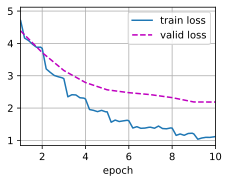

In [22]:
devices = d2l.try_all_gpus()
num_epochs, lr, wd = 10, 1e-4, 1e-4
lr_period, lr_decay, net = 2, 0.9, get_net(devices)
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)

#### 对测试集分类
- 通过`softmax`得到是有120列的**概率**tensor
  - 当得到的种类多时，更多的时候是关心前5个最高得分的类别
  - 与CIFAR-10得到种类结果不同

- `.join()`需要接收一个字符串列表作为参数

train loss 1.068, valid loss 2.101
475.7 examples/sec on [device(type='cuda', index=0)]


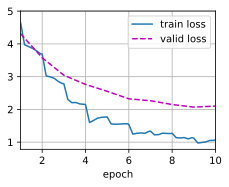

In [28]:
net = get_net(devices)
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period, lr_decay)

preds = []
for data, label in test_iter:
  output = nn.functional.softmax(net(data.to(devices[0])), dim=1)
  preds.extend(output.cpu().detach().numpy())
ids = sorted(os.listdir(
    os.path.join(drive_data_dir, 'train_valid_test', 'test', 'unknown')
))
with open('/content/drive/My Drive/ColabData/dog_tiny/submission.csv', 'w') as f:
  f.write('id,' + ','.join(train_valid_ds.classes) + '\n')
  for i, output in zip(ids, preds):
    f.write(
      i.split('.')[0] + ',' + ','.join(str(num) for num in output) + '\n'
    )

# 为什么过拟合这么严重？？

#### 对比
- 数据增强不同（图片变大+颜色变化）
- net选的更复杂一点的网络
- 使用fine-tuning
- 拿出所有的预测结果
